# Long Island Sound Chlorophyll-a Dynamics Tutorial

> History | Updated March 2025


## Objective

This tutorial will show the steps to grab daily chlorophyll-a data hosted on an ERDDAP server from Python, how to make temporal composites in Python and how to make some maps and time-series of chlorophyll-a


## The tutorial demonstrates the following techniques

- Locating a satellite product in ERDDAP, manually changing the constraints and copying the URL defining the data request
- Downloading the resulting netCDF file
- Opening and examining the netCDF file
- Calculate temporal composites (8Day and monthly)
- Spatially subset the dataset
- Making basic maps and time series plots


## Datasets used

**Long Island Sound Optimized water quailty datasets from OLCI**
Products developed by academic collaborators that have partnered with NOAA CoastWatch through a Sea Grant project titled “Actionable satellite water-quality data products in Long Island Sound for improved management and societal benefits”.
The dataset includes daily Sentinal-3 OLCI (300 m) water quality indicators:
-	Chlorophyll-a (Chla “chlor_a”)
-	Absorption coefficient of Chromophoric Dissolved Organic Material at 300 nm (aCDOM(300) “cdom”)
-	Dissolved Organic Carbon (DOC “doc”)
-	Suspended Particulate Matter (SPM “spm”).
Chlor_a, cdom and doc are based on Long Island Sound optimized algorithms. Spm retrieved using the Nechad Algorithm.

This dataset covers the Long Island Sound region between 40.2° N - 41.5° N and 74° W - 71.8° W

In this tutorial we will use the daily Chlorophyll-a dataset
The data will be downloaded from the CoastWatch ERRDAP server:
https://coastwatch.noaa.gov/erddap/griddap/noaacwappsS3ABcolorLISDaily.html 

for more information on each product refer to:
- Chla: https://www.sciencedirect.com/science/article/pii/S1569843223000456
- CDOM and DOC: https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2023JG007767
- SPM: https://www.sciencedirect.com/science/article/abs/pii/S0034425709003617





## Import Python modules

In [1]:
import urllib.request
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

## 1. Download data from ERDDAP using Python

Because ERDDAP includes RESTful services, you can download data listed on any ERDDAP platform from Python using the URL structure. 

For example, the following page allows you to download daily chlorophyll-a (chlor_a) https://coastwatch.noaa.gov/erddap/griddap/noaacwappsS3ABcolorLISDaily.html

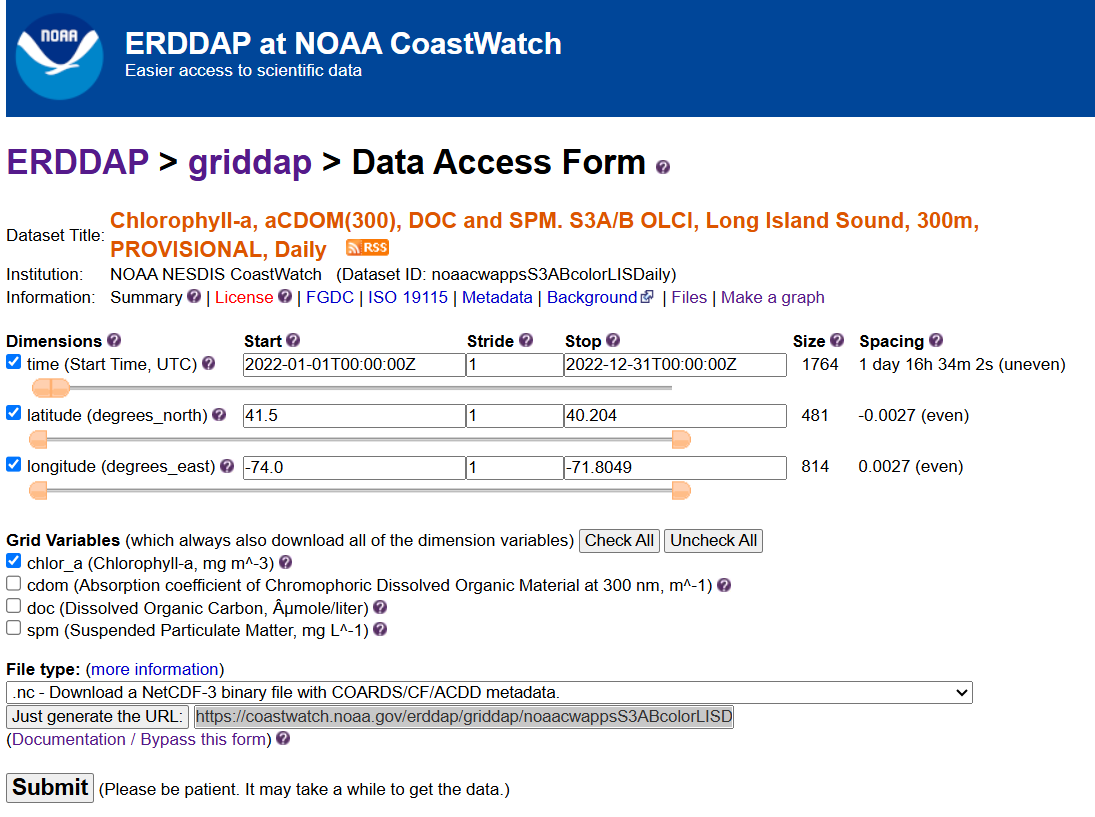

* Select the date range of interest, then select the '.nc' (NetCDF) file type and click on "Just Generate the URL".  

* In this specific example, the URL we generated is :  
https://coastwatch.noaa.gov/erddap/griddap/noaacwappsS3ABcolorLISDaily.nc?chlor_a%5B(2022-01-01T00:00:00Z):1:(2022-12-31T00:00:00Z)%5D%5B(41.5):1:(40.204)%5D%5B(-74.0):1:(-71.8049)%5D

### With Python, run the following to download the data using the generated URL .

In [2]:
url = ''.join(['https://coastwatch.noaa.gov/erddap/griddap/noaacwappsS3ABcolorLISDaily.nc?',
               'chlor_a',
               '%5B(2022-01-01T00:00:00Z):1:(2022-12-31T00:00:00Z)%5D',
               '%5B(41.5):1:(40.204)%5D',
               '%5B(-74.0):1:(-71.8049)%5D'
               ])

urllib.request.urlretrieve(url, "chlor_a_2022_LIS_tutorial.nc")

('chlor_a_2022_LIS_tutorial.nc', <http.client.HTTPMessage at 0x7f0c9c31b220>)

## 2. Loading netCDF4 data into Python

Now that we've downloaded the data locally, we can load it into Python and extract the variables of interest.

The xarray package makes it very convenient to work with NetCDF files. Documentation is available here:
http://xarray.pydata.org/en/stable/why-xarray.html

### Open the netCDF file as an xarray dataset object and examine the data structure.

In [3]:
ds = xr.open_dataset('chlor_a_2022_LIS_tutorial.nc', decode_cf=True)

### Examine which coordinates and variables are included in the dataset.

In [4]:
# List the coordinates
print('The coordinates variables:', list(ds.coords), '\n')

# List the data variables
print('The data variables:', list(ds.data_vars))

The coordinates variables: ['time', 'latitude', 'longitude'] 

The data variables: ['chlor_a']


### Examine the structure of chlor_a.

In [5]:
ds.chlor_a.shape

(365, 481, 814)

The dataset is a 3-D array with 365 time steps, each with 481 rows corresponding to latitudes and 814 columns corresponding to longitudes.

### List the dates for each time step.
The dataset has 365 time steps, one for each day between January 2022 and December 2022.  

In [6]:
ds.time

<xarray.DataArray 'time' (time: 365)> Size: 3kB
array(['2022-01-01T00:00:00.000000000', '2022-01-02T00:00:00.000000000',
       '2022-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 3kB 2022-01-01 2022-01-02 ... 2022-12-31
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [1.6409952e+09 1.6724448e+09]
    axis:                 T
    ioos_category:        Time
    long_name:            Start Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00

### Resample daily data monthly.
Use Xarray's resample function to group the data into a monthly dataset ("MS" = Month Start). You can then apply aggregation functions like .mean(), .median(), .sum(), .cumsum(), etc., to compute statistics for each month.

In [7]:
ds_mon = ds.resample(time="MS").mean()

### List the dates for each time step after resampling
The dataset now has 12 time steps, one for each month between January 2022 and December 2022.  

In [8]:
ds_mon.time

<xarray.DataArray 'time' (time: 12)> Size: 96B
array(['2022-01-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-05-01T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-07-01T00:00:00.000000000', '2022-08-01T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 96B 2022-01-01 2022-02-01 ... 2022-12-01
Attributes:
    _CoordinateAxisType:  Time
    actual_range:         [1.6409952e+09 1.6724448e+09]
    axis:                 T
    ioos_category:        Time
    long_name:            Start Time
    standard_name:        time
    time_origin:          01-JAN-1970 00:00:00

### Examine the latitude coordinate variable
Typically, the latitude coordinate variable will be in ascending order. However, in some datasets the order is reversed, i.e the order is descending.  

By examining the first and last values on our latitude array (below), we can see that the values are descending.  
* In practice what this means is that when you slice (subset) using latitude later in this tutorial, you will put the largest latitude value first.

In [9]:
print('First latitude value', ds.latitude[0].item())
print('Last latitude value', ds.latitude[-1].item())

First latitude value 41.5
Last latitude value 40.204


## 3. Working with the  data

### Creating a Faceted Plot of Monthly Mean Chlorophyll-a for 2022
In this example, we plot directly from an xarray object using its built-in .plot() method. This is a quick and convenient way to create faceted maps, though it offers limited control over layout and map styling compared to using matplotlib or cartopy directly.

The col and col_wrap arguments define which dimension to facet over (in this case, "time") and how many panels to display per row. The cbar_kwargs dictionary gives access to colorbar customization, such as setting the label and size.

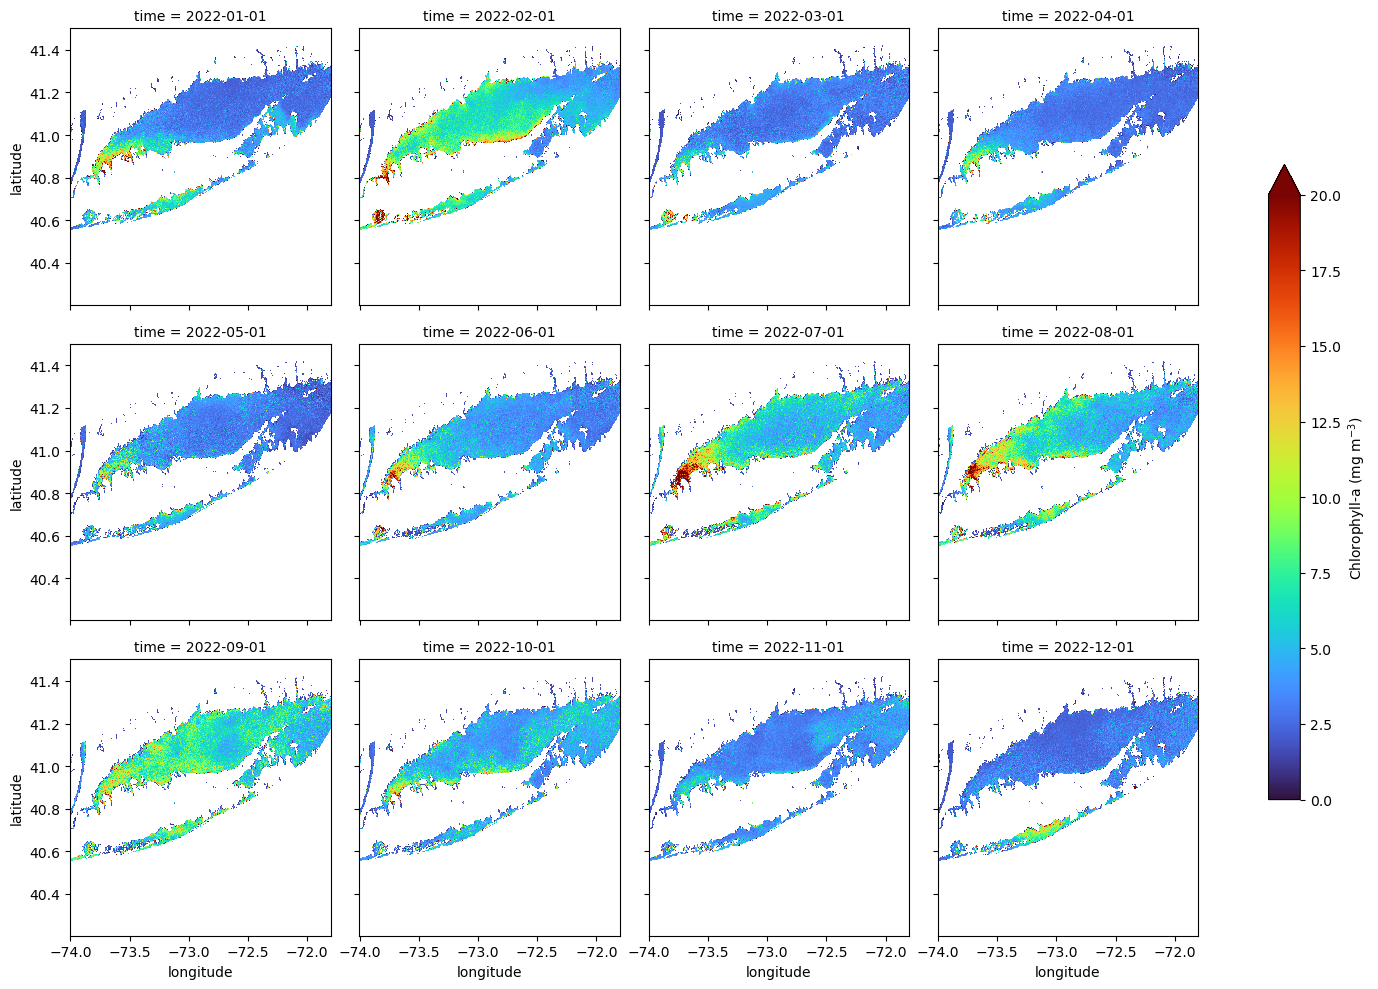

In [13]:
ds_mon.chlor_a.plot(col="time",
                    col_wrap=4,
                    cmap="turbo",
                    vmin=0, vmax=20,
                    figsize=(15, 10),
                    aspect=1.5,
                    cbar_kwargs={
                        'label': 'Chlorophyll-a (mg m$^{-3}$)',
                        'shrink': 0.7,
                        }
                        )

## Creating a Map of Average Chlorophyll-a Over the Year
### Compute the yearly mean for the region
Here we use NumPy's mean function to calculate the average chlorophyll-a across the time dimension (axis 0), resulting in a xarray dataarray of yearly mean values.

In [14]:
ds_yearly = np.mean(ds_mon.chlor_a, axis=0)

### Plot the map of the 2022 average SST in the region

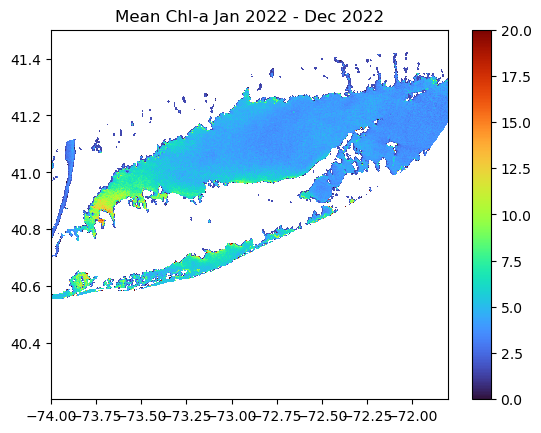

In [15]:
plt.pcolormesh(ds_yearly.longitude, ds_yearly.latitude, ds_yearly, cmap="turbo", vmin=0, vmax=20)
plt.colorbar()
plt.title("Mean Chl-a " 
          + ds_mon.time[0].dt.strftime('%b %Y').item() 
          + ' - '
          + ds_mon.time[11].dt.strftime('%b %Y').item())

plt.show()

## Spatial Subset and Time Series Comparing Chlorophyll-a Seasonal Cycles in Western and Eastern Long Island Sound

Subset the data
- West Long Island Ssound bewteen -73.9<sup>o</sup> to -73.1<sup>o</sup> W longitude
- East Long Island Ssound bewteen -72.9<sup>o</sup> to -71.8<sup>o</sup> W longitude

We are going to generate a time series of mean SST within each box.

In [16]:
da_west = ds.sel(longitude=slice(-73.9, -73.1))
da_east = ds.sel(longitude=slice(-72.9, -71.8))

### Examine the structure of the subsetted data.
The subsets are 3D arrays with 365 time steps, each with 481 rows corresponding to latitudes (full LIS latitudinal extent) and 296 / 406 columns corresponding to longitudes in the West and East, respectively.

In [17]:
print(f"West shape: {da_west.chlor_a.shape}")
print(f"West shape: {da_east.chlor_a.shape}")

West shape: (365, 481, 296)
West shape: (365, 481, 406)


### Resmaple each subset to an 8-Day means
Plotting a daily time series can often be messy, so we compute 8-day averages to smooth the data and highlight seasonal patterns.

In [18]:
da_west = da_west.resample(time="8D").mean()
da_east = da_east.resample(time="8D").mean()

### Compute a time series
Now, we will average all data within each subset across the latitude and longitude dimensions to produce a single time series.

In [19]:
west_TS = da_west.chlor_a.mean(dim=("latitude","longitude"))
east_TS = da_east.chlor_a.mean(dim=("latitude","longitude"))

### Plot the time-series

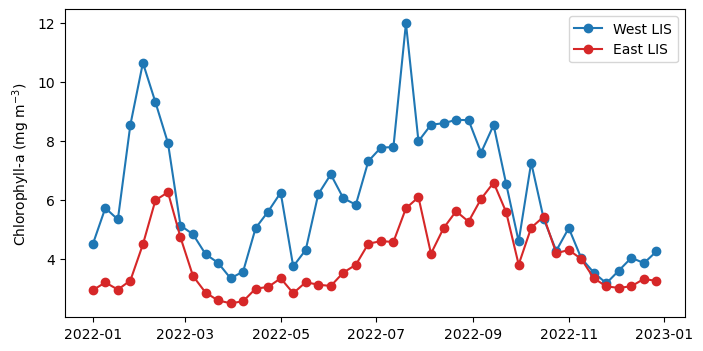

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(west_TS.time, west_TS, label="West LIS", marker="o", c="tab:blue")
plt.plot(east_TS.time, east_TS, label="East LIS", marker="o", c="tab:red")


plt.ylabel('Chlorophyll-a (mg m$^{-3}$)')
plt.legend()